In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

# Путь к данным
data_path = Path("/kaggle/input/datasets123")

# Список файлов
file_list = [
    "17.01.2020.xls", "27.03.2020.xls", "28.01.2021.xls", "30.03.2021.xls",
    "30.03.2022.xls", "30.06.2020.xls", "30.06.2021.xls", "30.06.2022.xls",
    "30.09.2020.xls", "30.09.2021.xls", "30.09.2022.xls", "31.01.2022.xls",
    "31.01.2023.xls", "31.03.2023.xls", "31.07.2023.xls"
]

def load_and_prepare_file(file_name: str) -> pd.DataFrame:
    """
    Загружает один файл Excel, пропуская первые 6 строк, 
    добавляет колонку с датой измерения (из имени файла) и возвращает DataFrame.
    """
    df = pd.read_excel(data_path / file_name, skiprows=6, header=[0, 1, 2])
    df["Дата"] = file_name[:-4]
    return df

# Загрузка и объединение данных
data = pd.concat([load_and_prepare_file(file) for file in file_list], ignore_index=True)
data['Дата'] = pd.to_datetime(data['Дата'], dayfirst=True)

# Удаление столбцов, содержащих более 30% пропусков
data = data.dropna(axis=1, thresh=0.7 * len(data))
data.columns = [
    ' '.join([part for part in col if not part.startswith('Unnamed')]).strip()
    for col in data.columns
]

# Оставляем только действующие нефтяные скважины пласта ПК1-3
data = data[
    (data["Месторождение Код"] == 11.0) & 
    (data["Пласт"] == "ПК1-3") & 
    (data["Назначение по проекту"] == "Нефтяные")
]

# Кодировка переменных типа скважины и системы эксплуатации
data = data.loc[:, data.nunique() > 1]

data['is_horis'] = np.where(data['Тип\nскважины'] == 'ГОР', 1, 0)
data['is_ESP'] = np.where(data['СЭ'] == 'ЭЦН', 1, 0)

# Аналитически отобраны признаки, которые точно не влияют на предсказание
to_drop = ['Тип насоса', 'ПЭД Марка', 'ГЗУ', 'Тип ГЗУ', 'Дата запуска после КРС', 'Дата остановки', 
           'Дата ввода в эксплу-атацию', 'Режим работы УЭЦН Комментарии', 'Режим работы УЭЦН Дата установки режима Описание', 'СЭ', 'Тип скважины']

to_drop_2 = ['Р пл на ВДП', 'Куст', 'Дата запуска', 'Группа фонда', 'Дополнительное оборудование Диаметр', 
             'Дополнительное оборудование Глубина спуска', 'Режим работы УЭЦН Режим', 'Режим работы УЭЦН Дата установки режима',
            'Номинальная производительность', 'Номинальный напор', 'Номинальный напор', 'Состояние на конец месяца',
            'Сравнение расчетов потенциала dQж при ГРП', 'Сравнение расчетов потенциала dQж при ГРП с корр',
            'Рзаб (геол огр индив)', 'Планируемый режим Q пг', 'ГФ', 'F', 'ГРП JD факт.',
            'Время до псевдоустановившегося режима', 'D э/к', 'D нкт', 'D шт']

to_drop_3 = ['Расчёт потенциала (Мин. Тех., Нсп(макс) , не ниже ВДП, Рзаб (утв),  огр Рзаб по скв) Р заб', 'Расчёт потенциала (Мин. Тех., Нсп(макс) , не ниже ВДП, Рзаб (утв),  огр Рзаб по скв) ИДН Q ж',
            'Расчёт потенциала (Мин. Тех., Нсп(макс) , не ниже ВДП, Рзаб (утв),  огр Рзаб по скв) ИДН Q ж  с поправкой на D э/к', 'Расчёт потенциала (Мин. Тех., Нсп(макс) , не ниже ВДП, Рзаб (утв),  огр Рзаб по скв) ИДН Q н',
            'Расчёт потенциала (Мин. Тех., Нсп(макс) , не ниже ВДП, Рзаб (утв),  огр Рзаб по скв) ИДН Прирост Q н', 'Расчёт потенциала (Мин. Тех., Нсп(макс) , не ниже ВДП, Рзаб (утв),  огр Рзаб по скв) % прироста Q н']

# Удаление лишних симоволов в названии колонок, изменен тип данных на int
data.columns = data.columns.str.replace(r'\n', ' ', regex=True)
data = data.drop(columns=(to_drop + to_drop_2 + to_drop_3))

# Преобразуем object в float
for col in data.select_dtypes(include=['object']).columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Добавление новых признаков – разность показателей между соседними измерениями
data['P пл разность'] = data.groupby("№ скв")['Р пл'].diff().fillna(0)
data['Qтеор разность'] = data.groupby("№ скв")['Qтеор'].diff().fillna(0)

# # Группировка данных по скважинам, заполнение пропусков средним значением
data = data[~data["№ скв"].isna()]
data.iloc[:, 1:] = data.groupby("№ скв").transform(lambda x: x.fillna(x.median()))
data = data.dropna()

# # Удаление выбросов в целовоей переменной КВЧ
data = data[data['Содер-жание мех-примесей (КВЧ)'] < 2000]
data = data.sort_values(["№ скв", "Дата"])

data

,№ скв,Н вдп,Удл,Н сп,Р буф,Р лин,Р пл,Н д,P затр,Р на приёме,...,Сравнение расчетов потенциала dQж при ИДН,Сравнение расчетов потенциала dQж при ИДН с корр,Сравнение расчетов потенциала dQн при ИДН,Удл (Нсп),Удл (Нд),Дата,is_horis,is_ESP,P пл разность,Qтеор разность
120,11.0,1248.10,418.07,702.410,19.0,15.9,66.597,435.0,18.0,34.71,...,534.425838,534.425838,70.704538,38.83,1.77,2020-01-17,1,1,0.000,0.0
508,11.0,1248.10,418.07,702.410,19.0,15.6,66.097,493.0,18.0,34.73,...,490.604051,490.604051,64.906916,38.83,4.46,2020-03-27,1,1,-0.500,0.0
2327,11.0,1248.10,418.07,702.410,20.0,16.0,64.597,398.0,17.0,41.16,...,707.432250,707.432250,46.796643,38.83,0.78,2020-06-30,1,1,4.200,-170.0
3736,11.0,1248.10,418.07,702.410,19.0,16.7,67.697,347.0,17.0,38.15,...,545.285582,545.285582,61.835385,38.83,0.14,2020-09-30,1,1,7.300,-130.0
879,11.0,1248.10,418.07,702.410,17.0,16.3,66.297,441.0,18.0,36.76,...,542.911492,542.911492,71.827190,38.83,1.98,2021-01-28,1,1,0.200,-112.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1286,8076.0,1411.63,517.18,802.247,25.0,24.0,61.103,705.0,24.0,29.68,...,19.021106,19.021106,17.615446,54.44,24.58,2021-03-30,1,1,-4.200,7.5
2675,8076.0,1411.63,517.18,802.247,27.0,24.3,54.003,774.0,26.0,25.13,...,12.679318,12.681000,11.743874,54.44,44.90,2021-06-30,1,1,-24.997,63.5
4111,8076.0,1411.63,517.18,802.247,28.0,27.1,54.303,785.0,28.0,27.87,...,14.786637,14.794000,13.700723,54.44,48.61,2021-09-30,1,1,-22.200,5.0
5148,8076.0,1411.63,517.18,802.247,27.0,27.2,56.203,792.0,27.0,29.68,...,3.170047,3.170047,2.935781,54.44,50.97,2022-01-31,1,1,1.900,-20.0


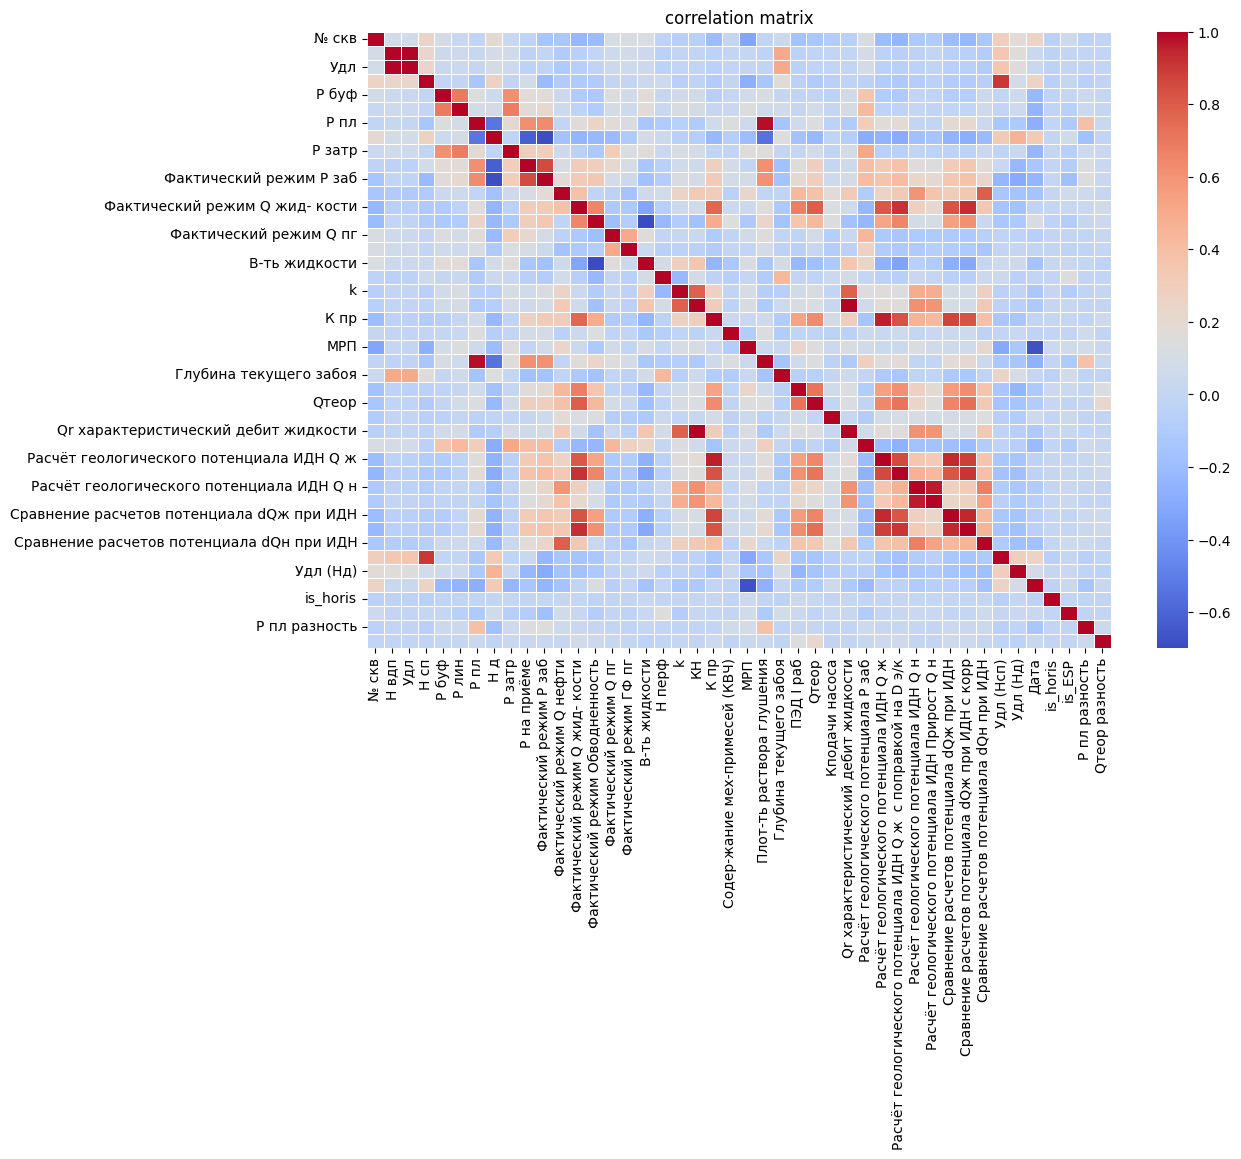

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Вычисляем корреляционную матрицу
corr_matrix = data.corr()

# Визуализация корреляционной матрицы с помощью heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("correlation matrix")
plt.show()

In [19]:
# Задаем порог для сильной корреляции
threshold = 0.7

# Создаем маску верхней треугольной части матрицы (без диагонали)
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
upper_tri = corr_matrix.where(mask)

# Преобразуем матрицу в DataFrame с парами признаков
strong_corr_pairs = (
    upper_tri.stack()
    .reset_index()
    .rename(columns={'level_0': 'Признак 1', 'level_1': 'Признак 2', 0: 'Корреляция'})
)

# Фильтруем только пары с абсолютной корреляцией выше порога
strong_corr_pairs = strong_corr_pairs[strong_corr_pairs['Корреляция'].abs() > threshold].sort_values('Корреляция', ascending=False)

strong_corr_pairs

,Признак 1,Признак 2,Корреляция
654,КН,Qr характеристический дебит жидкости,0.997389
43,Н вдп,Удл,0.994779
259,Р пл,Плот-ть раствора глушения,0.983272
880,Расчёт геологического потенциала ИДН Q н,Расчёт геологического потенциала ИДН Прирост Q н,0.960849
679,К пр,Расчёт геологического потенциала ИДН Q ж,0.957257
901,Сравнение расчетов потенциала dQж при ИДН,Сравнение расчетов потенциала dQж при ИДН с корр,0.942374
858,Расчёт геологического потенциала ИДН Q ж,Сравнение расчетов потенциала dQж при ИДН,0.935641
472,Фактический режим Q жид- кости,Сравнение расчетов потенциала dQж при ИДН с корр,0.922264
468,Фактический режим Q жид- кости,Расчёт геологического потенциала ИДН Q ж с по...,0.915565
871,Расчёт геологического потенциала ИДН Q ж с по...,Сравнение расчетов потенциала dQж при ИДН с корр,0.907594


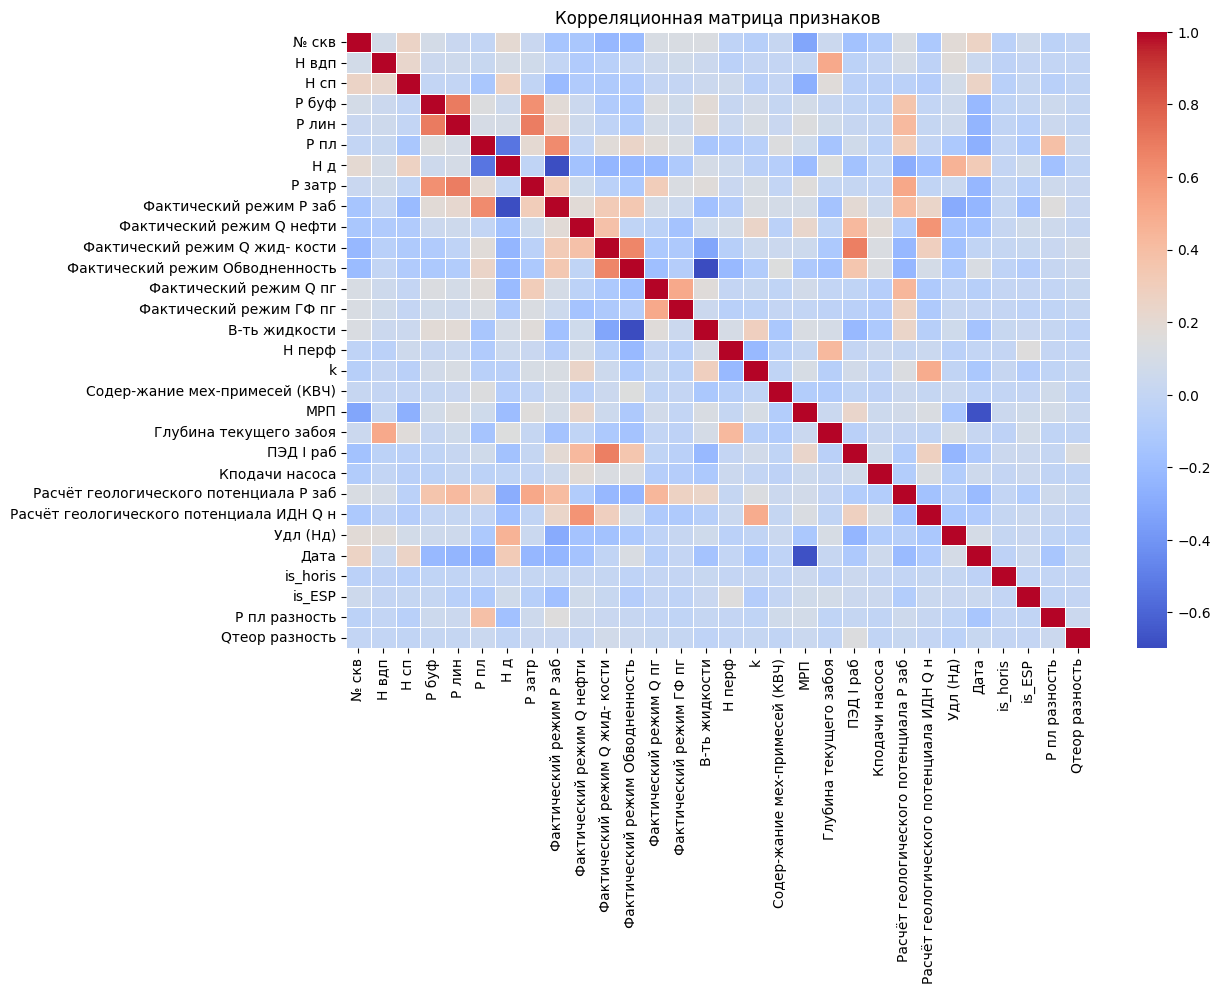

In [20]:
high_corelated_features = ['КН', 'Удл', 'Плот-ть раствора глушения', 
          'Расчёт геологического потенциала ИДН Прирост Q н',
         'Расчёт геологического потенциала ИДН Q ж',
         'Сравнение расчетов потенциала dQж при ИДН с корр',
         'Расчёт геологического потенциала ИДН Q ж  с поправкой на D э/к',
         'Удл (Нсп)', 'Сравнение расчетов потенциала dQж при ИДН',
         'Р на приёме', 'Qтеор', 'Сравнение расчетов потенциала dQн при ИДН',
         'Qr характеристический дебит жидкости', 'К пр']

data = data.drop(columns=high_corelated_features)

corr_matrix = data.corr()

# Визуализация корреляционной матрицы с помощью heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Корреляционная матрица признаков")
plt.show()

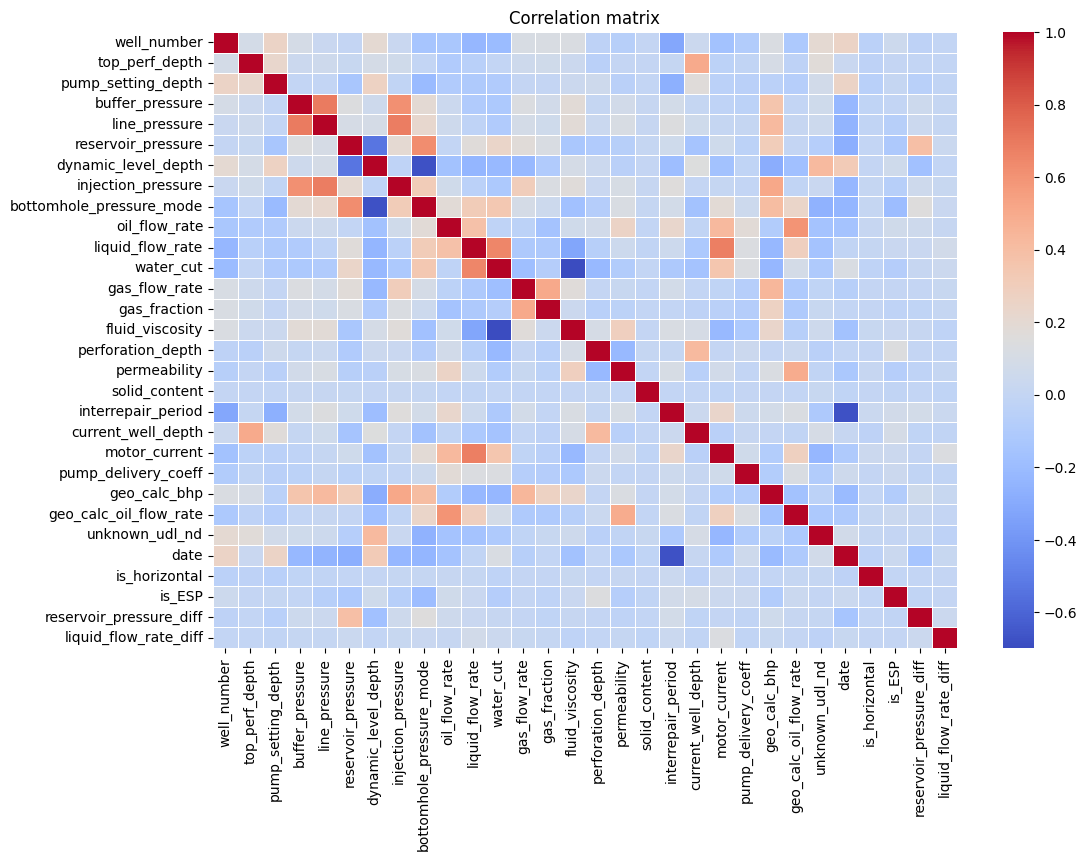

In [11]:
columns_en = [
    "well_number",                   # № скв
    "top_perf_depth",                # Н вдп — глубина до верхней дыры перфорации
    "pump_setting_depth",            # Н сп
    "buffer_pressure",               # Р буф
    "line_pressure",                 # Р лин
    "reservoir_pressure",            # Р пл
    "dynamic_level_depth",           # Н д
    "injection_pressure",            # P затр
    "bottomhole_pressure_mode",      # Фактический режим Р заб
    "oil_flow_rate",                 # Фактический режим Q нефти
    "liquid_flow_rate",              # Фактический режим Q жидкости
    "water_cut",                     # Фактический режим Обводненность
    "gas_flow_rate",                 # Фактический режим Q пг
    "gas_fraction",                  # Фактический режим ГФ пг
    "fluid_viscosity",               # В-ть жидкости
    "perforation_depth",             # Н перф
    "permeability",                  # k
    "solid_content",                 # Содержание мех. примесей (КВЧ)
    "interrepair_period",            # МРП — межремонтный период
    "current_well_depth",            # Глубина текущего забоя
    "motor_current",                 # ПЭД I раб
    "pump_delivery_coeff",           # Кподачи насоса
    "geo_calc_bhp",                  # Расчёт геологического потенциала Р заб
    "geo_calc_oil_flow_rate",        # Расчёт геологического потенциала ИДН Q н
    "unknown_udl_nd",                # Удл (Нд) — пока неясно, оставим как unknown
    "date",                          # Дата
    "is_horizontal",                 # is_horis
    "is_ESP",                        # is_ESP
    "reservoir_pressure_diff",       # P пл разность
    "liquid_flow_rate_diff",         # Qтеор разность
]

data.columns = columns_en

corr_matrix = data.corr()

# Визуализация корреляционной матрицы с помощью heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation matrix")
plt.savefig('my_image.png')
plt.show()

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


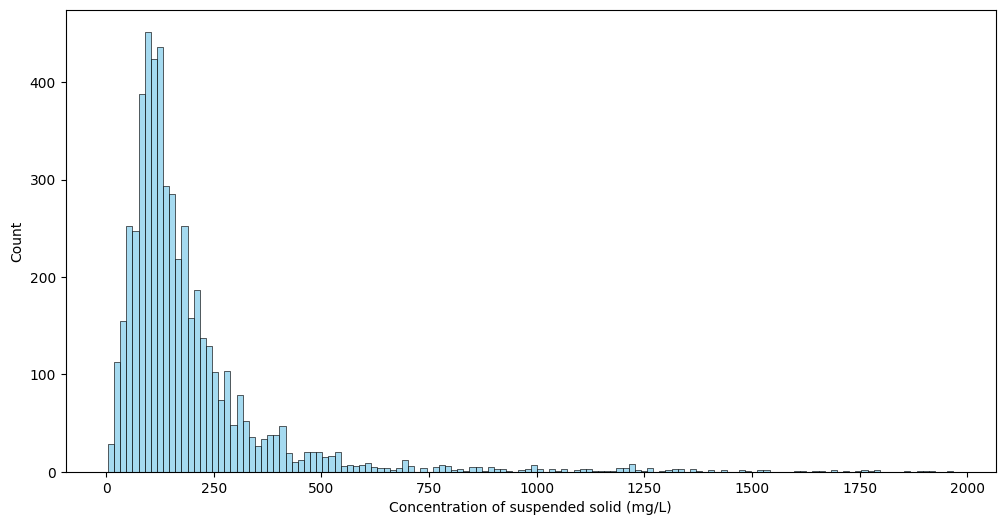

In [21]:
plt.figure(figsize=(12, 6))
sns.histplot(data['Содер-жание мех-примесей (КВЧ)'], color='skyblue');
plt.xlabel('Сoncentration of suspended solid (mg/L)')
plt.savefig('image.png')
plt.show()

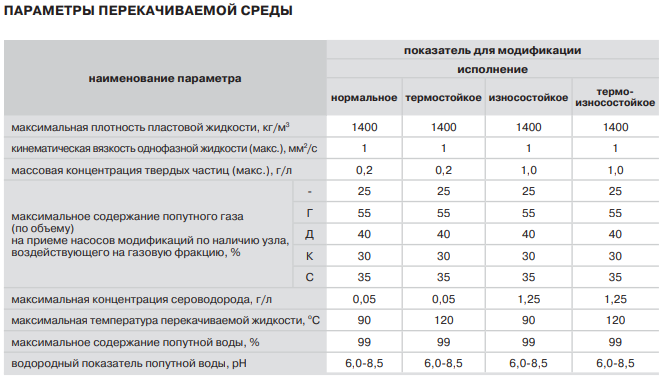

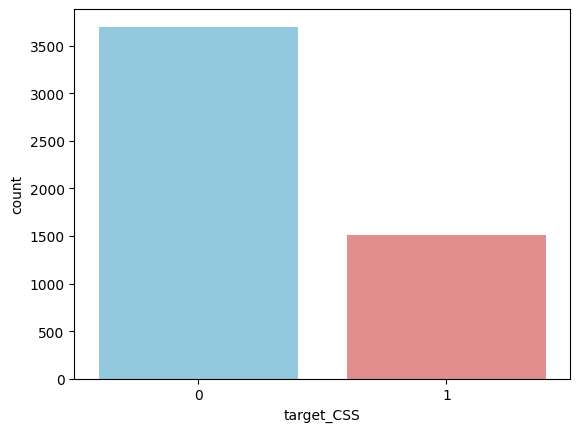

In [22]:
# critic = data['Содер-жание мех-примесей (КВЧ)'].mode()[0] + data['Содер-жание мех-примесей (КВЧ)'].std()
critic = 200

data.loc[:, 'target_CSS'] = np.where(data['Содер-жание мех-примесей (КВЧ)'] > critic, 1, 0)

sns.countplot(x=data['target_CSS'], palette={0: 'skyblue', 1: 'lightcoral'})

plt.savefig('image2.png')

In [23]:
columns_en = [
    "well_number",                   # № скв
    "top_perf_depth",                # Н вдп — глубина до верхней дыры перфорации
    "pump_setting_depth",            # Н сп
    "buffer_pressure",               # Р буф
    "line_pressure",                 # Р лин
    "reservoir_pressure",            # Р пл
    "dynamic_level_depth",           # Н д
    "injection_pressure",            # P затр
    "bottomhole_pressure_mode",      # Фактический режим Р заб
    "oil_flow_rate",                 # Фактический режим Q нефти
    "liquid_flow_rate",              # Фактический режим Q жидкости
    "water_cut",                     # Фактический режим Обводненность
    "gas_flow_rate",                 # Фактический режим Q пг
    "gas_fraction",                  # Фактический режим ГФ пг
    "fluid_viscosity",               # В-ть жидкости
    "perforation_depth",             # Н перф
    "permeability",                  # k
    "solid_content",                 # Содержание мех. примесей (КВЧ)
    "interrepair_period",            # МРП — межремонтный период
    "current_well_depth",            # Глубина текущего забоя
    "motor_current",                 # ПЭД I раб
    "pump_delivery_coeff",           # Кподачи насоса
    "geo_calc_bhp",                  # Расчёт геологического потенциала Р заб
    "geo_calc_oil_flow_rate",        # Расчёт геологического потенциала ИДН Q н
    "udl_nd",                # Удл (Нд) — пока неясно, оставим как unknown
    "date",                          # Дата
    "is_horizontal",                 # is_horis
    "is_ESP",                        # is_ESP
    "reservoir_pressure_diff",       # P пл разность
    "liquid_flow_rate_diff",         # Qтеор разность
    "target_TSP"                     # CRITIC_TSP
]


data.columns = columns_en

data["liquid_mobility"] = data["permeability"] / data["fluid_viscosity"]
data["filtration_resistance"] = (data["bottomhole_pressure_mode"] - data["line_pressure"]) / data["liquid_flow_rate"]

data

,well_number,top_perf_depth,pump_setting_depth,buffer_pressure,line_pressure,reservoir_pressure,dynamic_level_depth,injection_pressure,bottomhole_pressure_mode,oil_flow_rate,...,geo_calc_oil_flow_rate,udl_nd,date,is_horizontal,is_ESP,reservoir_pressure_diff,liquid_flow_rate_diff,target_TSP,liquid_mobility,filtration_resistance
120,11.0,1248.10,702.410,19.0,15.9,66.597,435.0,18.0,50.866132,67.076100,...,159.770163,1.77,2020-01-17,1,1,0.000,0.0,0,10.713933,0.068967
508,11.0,1248.10,702.410,19.0,15.6,66.097,493.0,18.0,50.850685,61.519500,...,150.230541,4.46,2020-03-27,1,1,-0.500,0.0,0,10.135139,0.075808
2327,11.0,1248.10,702.410,20.0,16.0,64.597,398.0,17.0,57.413605,23.152500,...,117.530987,0.78,2020-06-30,1,1,4.200,-170.0,0,15.951940,0.118325
3736,11.0,1248.10,702.410,19.0,16.7,67.697,347.0,17.0,54.620982,45.927000,...,133.379296,0.14,2020-09-30,1,1,7.300,-130.0,0,10.235422,0.093632
879,11.0,1248.10,702.410,17.0,16.3,66.297,441.0,18.0,53.352050,57.317387,...,163.207472,1.98,2021-01-28,1,1,0.200,-112.0,0,11.080618,0.085524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1286,8076.0,1411.63,802.247,25.0,24.0,61.103,705.0,24.0,38.008006,17.615348,...,17.615446,24.58,2021-03-30,1,1,-4.200,7.5,0,0.132848,0.736450
2675,8076.0,1411.63,802.247,27.0,24.3,54.003,774.0,26.0,35.254687,11.743874,...,11.743874,44.90,2021-06-30,1,1,-24.997,63.5,0,0.107338,0.863866
4111,8076.0,1411.63,802.247,28.0,27.1,54.303,785.0,28.0,41.307623,13.700723,...,13.700723,48.61,2021-09-30,1,1,-22.200,5.0,1,0.171017,0.960364
5148,8076.0,1411.63,802.247,27.0,27.2,56.203,792.0,27.0,37.927481,2.935737,...,2.935781,50.97,2022-01-31,1,1,1.900,-20.0,0,0.027219,3.384063


In [14]:
import numpy as np
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold, cross_val_score

data["well_number"] = data["well_number"].astype(str) # Тестируем учитывание номера скважины
# Определяем столбцы, которые не будем использовать в качестве признаков
exclude_cols = ['solid_content', 'target_CSS']
X = data.drop(columns=exclude_cols)
y = data['target_CSS']

def objective(trial):
    # Задаём пространство гиперпараметров для оптимизации
    params = {
        'iterations': trial.suggest_int('iterations', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 10),
        'cat_features': ["well_number"],
        'random_seed': 42,
        'loss_function': 'Logloss',
        'eval_metric': 'F1',   # Используем F1 как метрику
        'verbose': 250,
        'class_weights': [1.0, trial.suggest_float('class_weight', 0.5, 3.0)],
        # 'task_type': 'GPU'  # Включаем использование GPU
    }
    
    model = CatBoostClassifier(**params)
    
    # StratifiedKFold для сохранения пропорций классов в фолдах
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    # Кросс-валидация с метрикой F1.
    # Важно: при использовании GPU не запускайте параллельные воркеры, поэтому n_jobs=1.
    scores = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1)
    
    # Используем среднее значение F1 по всем фолдам
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
# Запуск оптимизации на 50 испытаниях
study.optimize(objective, n_trials=50)

print("Best F1:", study.best_value)
print("Best parameters:", study.best_params)

[I 2025-04-08 15:25:49,601] A new study created in memory with name: no-name-d9bd11a4-3873-47c8-91de-7306df5857b8
[I 2025-04-08 15:26:01,084] Trial 0 finished with value: 0.398468683349911 and parameters: {'iterations': 312, 'learning_rate': 0.018751403184197133, 'depth': 6, 'l2_leaf_reg': 2, 'class_weight': 1.5878197114646138}. Best is trial 0 with value: 0.398468683349911.
[I 2025-04-08 15:26:23,457] Trial 1 finished with value: 0.39429442648875956 and parameters: {'iterations': 175, 'learning_rate': 0.14105121204367715, 'depth': 10, 'l2_leaf_reg': 5, 'class_weight': 1.5483002841051046}. Best is trial 0 with value: 0.398468683349911.
[I 2025-04-08 15:27:30,209] Trial 2 finished with value: 0.35143840172651064 and parameters: {'iterations': 521, 'learning_rate': 0.04909865407069497, 'depth': 10, 'l2_leaf_reg': 6, 'class_weight': 1.0383441566486933}. Best is trial 0 with value: 0.398468683349911.
[I 2025-04-08 15:27:48,585] Trial 3 finished with value: 0.42719844527464906 and parameter

KeyboardInterrupt: 

In [24]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report

# Исключаем ненужные столбцы
exclude_cols = ['solid_content', 'target_TSP', 'date']
X = data.drop(columns=exclude_cols)
y = data['target_TSP']

# Разбиваем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Преобразуем 'well_number' в категориальный тип
X_train['well_number'] = X_train['well_number'].astype(str)
X_test['well_number'] = X_test['well_number'].astype(str)

# Формируем пулы данных для CatBoost
train_pool = Pool(X_train, y_train, cat_features=['well_number'])
eval_pool = Pool(X_test, y_test, cat_features=['well_number'])

# Создаём модель CatBoostClassifier с оптимизированными параметрами
model = CatBoostClassifier(
    iterations=213,
    learning_rate=0.028167482144490177,
    depth=6,
    l2_leaf_reg=6,
    cat_features=['well_number'], 
    loss_function='Logloss',   
    eval_metric='F1',         
    class_weights={0: 1.0, 1: 2.9846596902514664},
    random_seed=42,
    verbose=100
)

# Обучаем модель
model.fit(train_pool)

# Предсказываем вероятности для тестовой выборки
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Конвертируем вероятности в бинарные предсказания (порог 0.5)
y_pred = (y_pred_proba > 0.5).astype(int)

# Оцениваем качество модели
precision_score = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Выводим метрики
print("Precision score: ", precision_score)
print("Recall: ", recall)
print("F1 score: ", f1)

print(classification_report(y_test, y_pred))

thresholds = np.arange(0, 1, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_t = (y_pred_proba >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_t))

# Находим порог, максимизирующий F1
best_threshold = thresholds[np.argmax(f1_scores)]
print("Best threshold for F1:", best_threshold)
print("Best F1 score:", np.max(f1_scores))

0:	learn: 0.6842058	total: 10.9ms	remaining: 2.3s
100:	learn: 0.7432454	total: 807ms	remaining: 895ms
200:	learn: 0.7851439	total: 1.6s	remaining: 95.3ms
212:	learn: 0.7894600	total: 1.69s	remaining: 0us
Precision score:  0.3954802259887006
Recall:  0.695364238410596
F1 score:  0.504201680672269
              precision    recall  f1-score   support

           0       0.82      0.57      0.67       740
           1       0.40      0.70      0.50       302

    accuracy                           0.60      1042
   macro avg       0.61      0.63      0.59      1042
weighted avg       0.70      0.60      0.62      1042

Best threshold for F1: 0.53
Best F1 score: 0.5204755614266844


In [25]:
import shap
import matplotlib.pyplot as plt

explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Создаем график
shap.summary_plot(shap_values, X_test, show=False)

# # Сохраняем график в файл
plt.savefig('shap_summary.png', dpi=300, bbox_inches='tight')
plt.close()  # закрыть, чтобы не отображался в output, если не нужно

---------------------------------------------СТЕКИНГ--------------------------------------------------------------

In [27]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer

def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'class_weight': 'balanced',
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestClassifier(**params)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring=make_scorer(f1_score)).mean()
    return score

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=25)

print("Best params for RandomForest:")
print(study_rf.best_params)

[I 2025-04-08 15:34:38,604] A new study created in memory with name: no-name-ba5d913a-09ce-4e7a-894b-d314afa95713
[I 2025-04-08 15:34:40,129] Trial 0 finished with value: 0.4798710045929136 and parameters: {'n_estimators': 136, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.4798710045929136.
[I 2025-04-08 15:34:44,412] Trial 1 finished with value: 0.4769650493222057 and parameters: {'n_estimators': 355, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.4798710045929136.
[I 2025-04-08 15:34:49,888] Trial 2 finished with value: 0.4797320026911864 and parameters: {'n_estimators': 520, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.4798710045929136.
[I 2025-04-08 15:34:55,509] Trial 3 finished with value: 0.43950829132900626 and parameters: {'n_estimators': 397, 'max_depth': 20, 'm

Best params for RandomForest:
{'n_estimators': 121, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 9, 'max_features': 'log2'}


In [28]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

X_train['well_number'] = X_train['well_number'].astype('category')
X_test['well_number'] = X_test['well_number'].astype('category')

def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0, 3),
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'random_state': 42,
        'n_jobs': -1,
        'enable_categorical': True
    }

    model = xgb.XGBClassifier(**params)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring=make_scorer(f1_score)).mean()
    return score

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=30)

print("Best params for XGBoost:")
print(study_xgb.best_params)

[I 2025-04-08 15:38:10,721] A new study created in memory with name: no-name-beab8dd2-527c-4648-bf12-13a18287837c
[I 2025-04-08 15:38:11,317] Trial 0 finished with value: 0.2645012725961717 and parameters: {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.09146541107152617, 'subsample': 0.5725508276424289, 'colsample_bytree': 0.8270659907739056, 'gamma': 3.287793507617782, 'reg_alpha': 3.7763356402668817, 'reg_lambda': 1.6495718822192773, 'scale_pos_weight': 1.085856353337844}. Best is trial 0 with value: 0.2645012725961717.
[I 2025-04-08 15:38:12,004] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 411, 'max_depth': 9, 'learning_rate': 0.056666189632714095, 'subsample': 0.6988900808319425, 'colsample_bytree': 0.5580335425482794, 'gamma': 1.8773635686934875, 'reg_alpha': 3.550550338810358, 'reg_lambda': 2.872664486530053, 'scale_pos_weight': 0.33266024047280573}. Best is trial 0 with value: 0.2645012725961717.
[I 2025-04-08 15:38:14,789] Trial 2 finished with v

Best params for XGBoost:
{'n_estimators': 489, 'max_depth': 5, 'learning_rate': 0.028982595114918578, 'subsample': 0.9985540294557392, 'colsample_bytree': 0.7841105465305576, 'gamma': 1.7096737170844212, 'reg_alpha': 2.862300205135389, 'reg_lambda': 3.758600593820647, 'scale_pos_weight': 2.839347050707216}


In [26]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

X_train['well_number'] = X_train['well_number'].astype('category')
X_test['well_number'] = X_test['well_number'].astype('category')

# 1. Инициализация базовых моделей
rf = RandomForestClassifier(
    n_estimators=806,
    max_depth=5,
    min_samples_split=4,
    min_samples_leaf=6,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

xgb_params = {'n_estimators': 314, 'max_depth': 6, 'learning_rate': 0.015531758891649698, 'subsample': 0.7647734408177513, 'colsample_bytree': 0.6109327432320895, 'gamma': 3.767648658524026, 'reg_alpha': 2.388080806769236, 'reg_lambda': 4.705508691402083}
xgb_model = xgb.XGBClassifier(
    **xgb_params,
    scale_pos_weight=2.98,  # дисбаланс классов
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1,
    enable_categorical=True
)

catboost_model = CatBoostClassifier(
    iterations=213,
    learning_rate=0.028167482144490177,
    depth=6,
    l2_leaf_reg=6,
    cat_features=['well_number'],
    loss_function='Logloss',
    eval_metric='F1',
    class_weights={0: 1.0, 1: 2.9846596902514664},
    random_seed=42,
    verbose=0
)

# meta_model = make_pipeline(
#     StandardScaler(),
#     LogisticRegression(max_iter=5000, class_weight='balanced', solver='liblinear', penalty='l1')  # F1-score стекинга: 0.5161290322580645
# )

params = {'n_estimators': 108, 'max_depth': 3, 'learning_rate': 0.026705224525825758, 'subsample': 0.5791960655433243, 
             'colsample_bytree': 0.9259911572434968, 'reg_alpha': 0.8469446251774863, 'reg_lambda': 2.260395031300451} 
# F1-score стекинга: 0.517814726840855 cv=5 passthrough=False,
meta_model = XGBClassifier(
    **params,
    random_state=42,
    scale_pos_weight=2.98,
    n_jobs=-1
)

stacking_clf = StackingClassifier(
    estimators=[
        ('rf', rf),
        ('xgb', xgb_model),
        ('cat', catboost_model)
    ],
    final_estimator=meta_model,
    passthrough=False,
    n_jobs=-1,
    cv=5
)

# 3. Обучение (для CatBoost надо отдельно указать cat_features — только при .fit)
stacking_clf.fit(X_train, y_train)

# 4. Предсказание и метрики
y_pred_stack = stacking_clf.predict(X_test)
print(classification_report(y_test, y_pred_stack))
print("F1-score стекинга:", f1_score(y_test, y_pred_stack))

              precision    recall  f1-score   support

           0       0.83      0.56      0.67       740
           1       0.40      0.72      0.52       302

    accuracy                           0.61      1042
   macro avg       0.62      0.64      0.60      1042
weighted avg       0.71      0.61      0.63      1042

F1-score стекинга: 0.517814726840855


In [85]:
import optuna
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_score

# Заранее определённые базовые модели
base_models = [
    ('rf', rf),
    ('xgb', xgb_model),
    ('cat', catboost_model)
]

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0, 3),
        'random_state': 42,
        'n_jobs': -1,
        'eval_metric': 'logloss',
        'use_label_encoder': False
    }

    meta_model = XGBClassifier(**params)

    stacking_clf = StackingClassifier(
        estimators=base_models,
        final_estimator=meta_model,
        passthrough=False,
        n_jobs=-1,
        cv=3
    )

    score = cross_val_score(stacking_clf, X_train, y_train, cv=3, scoring='f1', n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Лучшие параметры мета-модели XGBoost:")
print(study.best_params)

[I 2025-04-08 16:17:06,567] A new study created in memory with name: no-name-75ef6115-5a48-4a32-9130-9a6fe3aa62a7
[I 2025-04-08 16:17:50,788] Trial 0 finished with value: 0.16016194254296542 and parameters: {'n_estimators': 246, 'max_depth': 2, 'learning_rate': 0.03678143774091855, 'subsample': 0.763096785605547, 'colsample_bytree': 0.9636028609793077, 'reg_alpha': 0.6049610160956139, 'reg_lambda': 2.4814572405860846, 'scale_pos_weight': 0.7855720721142657}. Best is trial 0 with value: 0.16016194254296542.
[I 2025-04-08 16:18:35,204] Trial 1 finished with value: 0.25409892572625065 and parameters: {'n_estimators': 298, 'max_depth': 6, 'learning_rate': 0.10303338643290007, 'subsample': 0.7207943473915568, 'colsample_bytree': 0.9912577095286597, 'reg_alpha': 0.46649513905211804, 'reg_lambda': 2.3187739429717857, 'scale_pos_weight': 0.780506541473664}. Best is trial 1 with value: 0.25409892572625065.
[I 2025-04-08 16:19:18,108] Trial 2 finished with value: 0.1038297805047465 and parameter

Лучшие параметры мета-модели XGBoost:
{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.08058409675264429, 'subsample': 0.5011941829507547, 'colsample_bytree': 0.61528594747312, 'reg_alpha': 0.0589055744945447, 'reg_lambda': 0.45742994711687146, 'scale_pos_weight': 2.8176488442761514}


------------------------------------------------------------------------------------------------------------

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np

# Исключаем ненужные столбцы
exclude_cols = ['solid_content', 'date', 'target_TSP']  # Укажите нужные столбцы
X = data.drop(columns=exclude_cols)
y = data['target_TSP']

# Разбиваем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Модель, которая случайным образом выбирает класс
np.random.seed(42)
y_pred = np.random.choice([0, 1], size=len(y_test))

# Оценка модели с использованием F1-метрики
f1 = f1_score(y_test, y_pred)

# Выводим результат
print("F1 score (случайное предсказание):", f1)

F1 score (случайное предсказание): 0.39036144578313253


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
import pandas as pd

# Исключаем ненужные столбцы (если нужно)
exclude_cols = ['solid_content', 'date', 'target_TSP']  # Укажите нужные столбцы
X = data.drop(columns=exclude_cols)
y = data['target_TSP']

# Разбиваем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Создаём модель логистической регрессии
model = LogisticRegression(max_iter=5000, random_state=42)

# Обучаем модель
model.fit(X_train, y_train)

# Предсказываем значения для тестовой выборки
y_pred = model.predict(X_test)

# Оценка модели с использованием F1-метрики
f1 = f1_score(y_test, y_pred)

# Выводим результат
print(classification_report(y_test, y_pred))
print("F1 score: ", f1)

              precision    recall  f1-score   support

           0       0.72      0.98      0.83       740
           1       0.59      0.07      0.12       302

    accuracy                           0.72      1042
   macro avg       0.65      0.52      0.47      1042
weighted avg       0.68      0.72      0.62      1042

F1 score:  0.11904761904761905


In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Исключаем ненужные столбцы
exclude_cols = ['solid_content', 'date', 'target_TSP']  # Укажите нужные столбцы
X = data.drop(columns=exclude_cols)
y = data['target_TSP']

# Разбиваем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Масштабирование данных (опционально, но может помочь)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Создаём модель случайного леса
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Обучаем модель
model.fit(X_train_scaled, y_train)

# Предсказываем значения для тестовой выборки
y_pred = model.predict(X_test_scaled)

# Оценка модели с использованием F1-метрики
f1 = f1_score(y_test, y_pred)

# Выводим результат
print(classification_report(y_test, y_pred))
print("F1 score: ", f1)

              precision    recall  f1-score   support

           0       0.74      0.97      0.84       740
           1       0.65      0.15      0.24       302

    accuracy                           0.73      1042
   macro avg       0.69      0.56      0.54      1042
weighted avg       0.71      0.73      0.66      1042

F1 score:  0.23783783783783785
